In [1]:
%load_ext autoreload
%autoreload 2
import sys

import matplotlib.pyplot as plt
import numpy as np
import skimage
import sklearn
import spateo as st
import dynamo as dyn
import cv2
import anndata
import pandas as pd
from scipy import stats

import scanpy as sc
import besca

plt.style.use('default')
plt.rcParams['image.interpolation'] = 'none'
%config InlineBackend.figure_format='retina'

/Users/jingzehua/opt/anaconda3/envs/spateo/lib/python3.8/site-packages/geopandas-0.10.2-py3.8.egg/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


/Users/jingzehua/opt/anaconda3/envs/spateo/lib/python3.8/site-packages/dynamo/configuration.py:293: UserWarning: Trying to register the cmap 'fire' which already exists.
  plt.register_cmap("fire", fire_cmap)
/Users/jingzehua/opt/anaconda3/envs/spateo/lib/python3.8/site-packages/dynamo/configuration.py:294: UserWarning: Trying to register the cmap 'darkblue' which already exists.
  plt.register_cmap("darkblue", darkblue_cmap)
/Users/jingzehua/opt/anaconda3/envs/spateo/lib/python3.8/site-packages/dynamo/configuration.py:295: UserWarning: Trying to register the cmap 'darkgreen' which already exists.
  plt.register_cmap("darkgreen", darkgreen_cmap)
/Users/jingzehua/opt/anaconda3/envs/spateo/lib/python3.8/site-packages/dynamo/configuration.py:296: UserWarning: Trying to register the cmap 'darkred' which already exists.
  plt.register_cmap("darkred", darkred_cmap)
/Users/jingzehua/opt/anaconda3/envs/spateo/lib/python3.8/site-packages/dynamo/configuration.py:297: UserWarning: Trying to regis

In [2]:
mtx_path = "matrix.txt.gz"
tif_path = "ssDNA.tif"
seg_path = "full_segmentation.h5ad"
cell_label_path = "adata_cell_labels.h5ad"

In [3]:
segmentation_adata = anndata.read(seg_path)
segmentation_adata

AnnData object with n_obs × n_vars = 10509 × 13646
    uns: '__type', 'spatial'
    layers: 'X_bins', 'X_labels', 'X_labels_expanded', 'X_mask', 'X_scores', 'cell_labels', 'cell_labels_expanded', 'nuclear', 'nuclear_labels', 'nuclear_mask', 'nuclear_scores', 'spliced', 'stain', 'stain_cell_mask', 'stain_labels', 'stain_markers', 'stain_mask', 'unspliced', 'unspliced_bins', 'unspliced_labels', 'unspliced_mask', 'unspliced_scores'

In [4]:
cell_label_adata = anndata.read(cell_label_path)
cell_label_adata

AnnData object with n_obs × n_vars = 60143 × 25567
    obs: 'area'
    uns: '__type', 'spatial'
    obsm: 'bbox', 'contour', 'spatial'
    layers: 'spliced', 'unspliced'

In [5]:
%%time
adata = st.io.read_bgi(
    mtx_path,
    binsize=50
)

|-----> Using binsize=50
|-----> Constructing count matrices.
|-----> <insert> __type to uns in AnnData Object.
|-----> <insert> pp to uns in AnnData Object.
|-----> <insert> spatial to uns in AnnData Object.
CPU times: user 2min 9s, sys: 14.4 s, total: 2min 23s
Wall time: 2min 23s


(<Figure size 400x400 with 1 Axes>, <AxesSubplot:>)

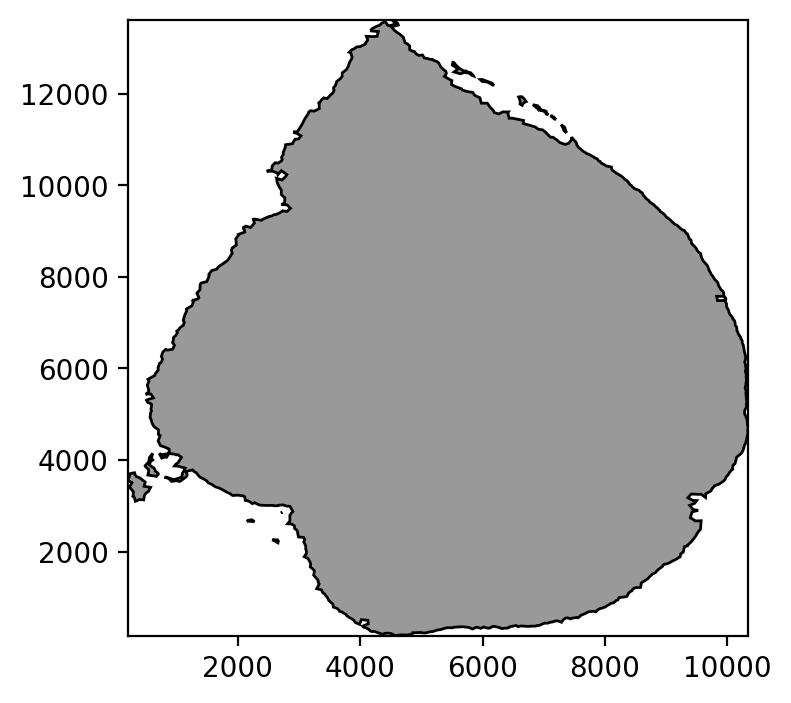

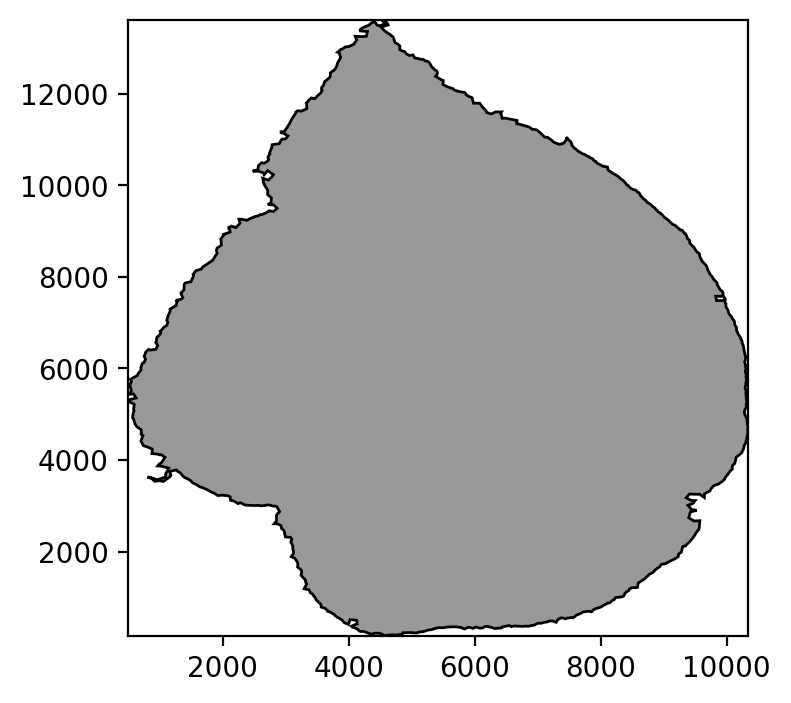

In [6]:
alpha1 = st.io.alpha_shape(cell_label_adata.obsm['spatial'][:,0],
                           cell_label_adata.obsm['spatial'][:,1],
                           alpha=0.015)
st.pl.polygon(alpha1[0], figsize=(4, 4))
st.pl.polygon(alpha1[0][6], figsize=(4, 4))

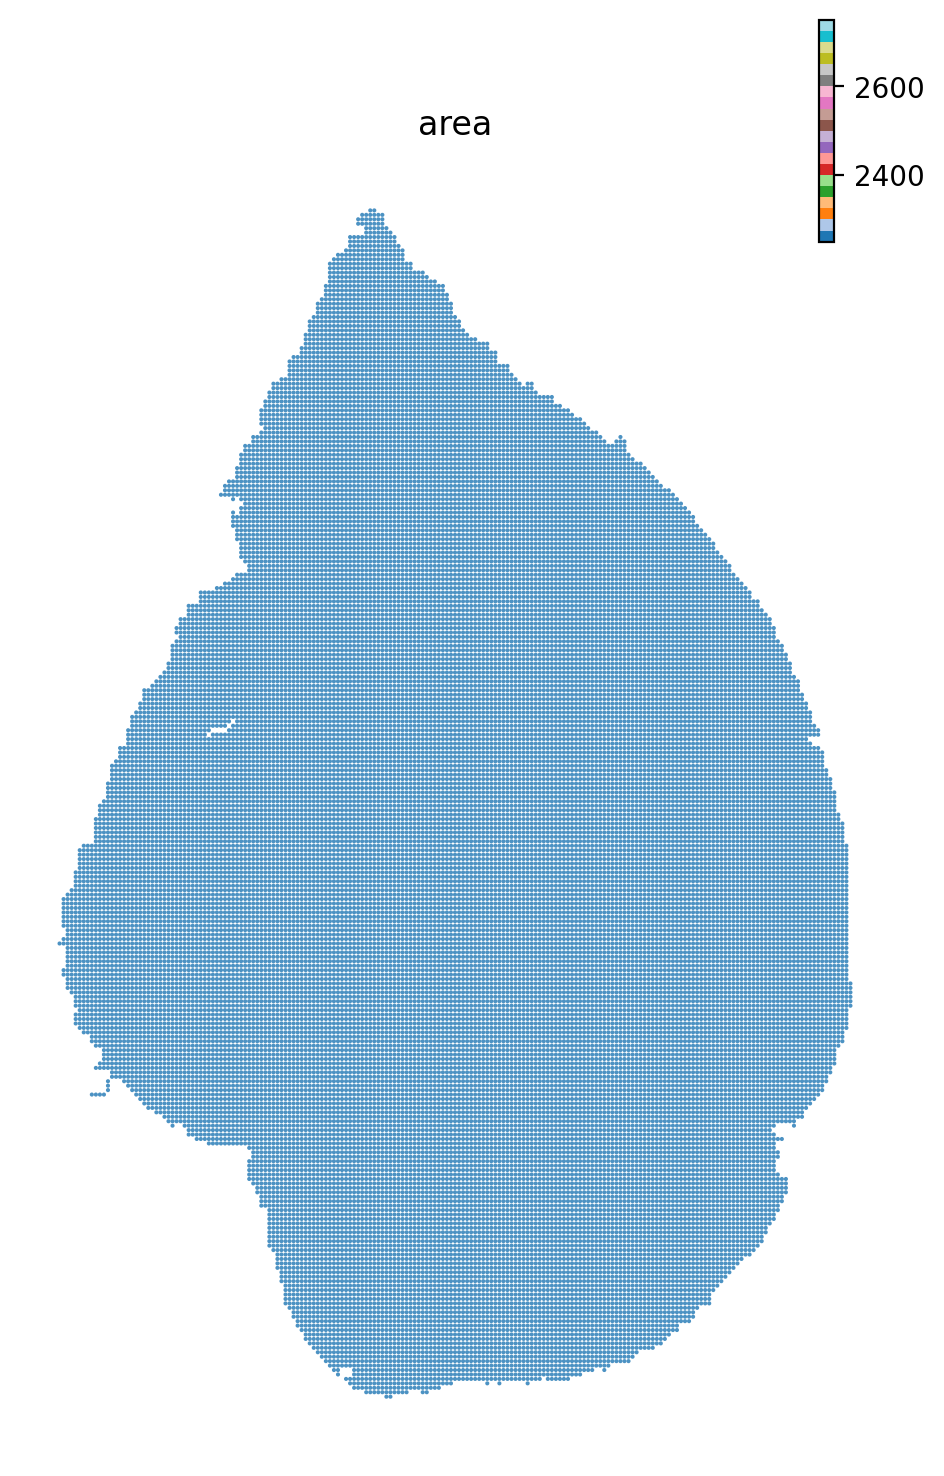

In [7]:
adata = adata[st.io.utils.in_concave_hull(adata.obsm['spatial'], alpha1[0][6]), :]
st.pl.space(adata, color=['area'], pointsize=0.1, show_legend="upper left", cmap="tab20")
adata.write('adata_bin50_concave_hull_ver.h5ad', compression='gzip')

In [8]:
#adata.obsm['tissue_mask'] = np.array([segmentation_adata.layers['unspliced_bins'][int(i[0]-25), int(i[1]-25)] for i in adata.obsm['X_spatial']])
#adata = adata[adata.obsm['tissue_mask'] != 0, :]
#st.pl.space(adata, color=['area'], pointsize=0.1, show_legend="upper left", cmap="tab20")
#adata.write('adata_bin50.h5ad', compression='gzip')

In [3]:
adata = anndata.read('adata_bin50_concave_hull_ver.h5ad')
adata

AnnData object with n_obs × n_vars = 33836 × 26274
    obs: 'area'
    uns: '__type', 'spatial'
    obsm: 'X_spatial', 'bbox', 'contour', 'spatial'
    layers: 'spliced', 'unspliced'

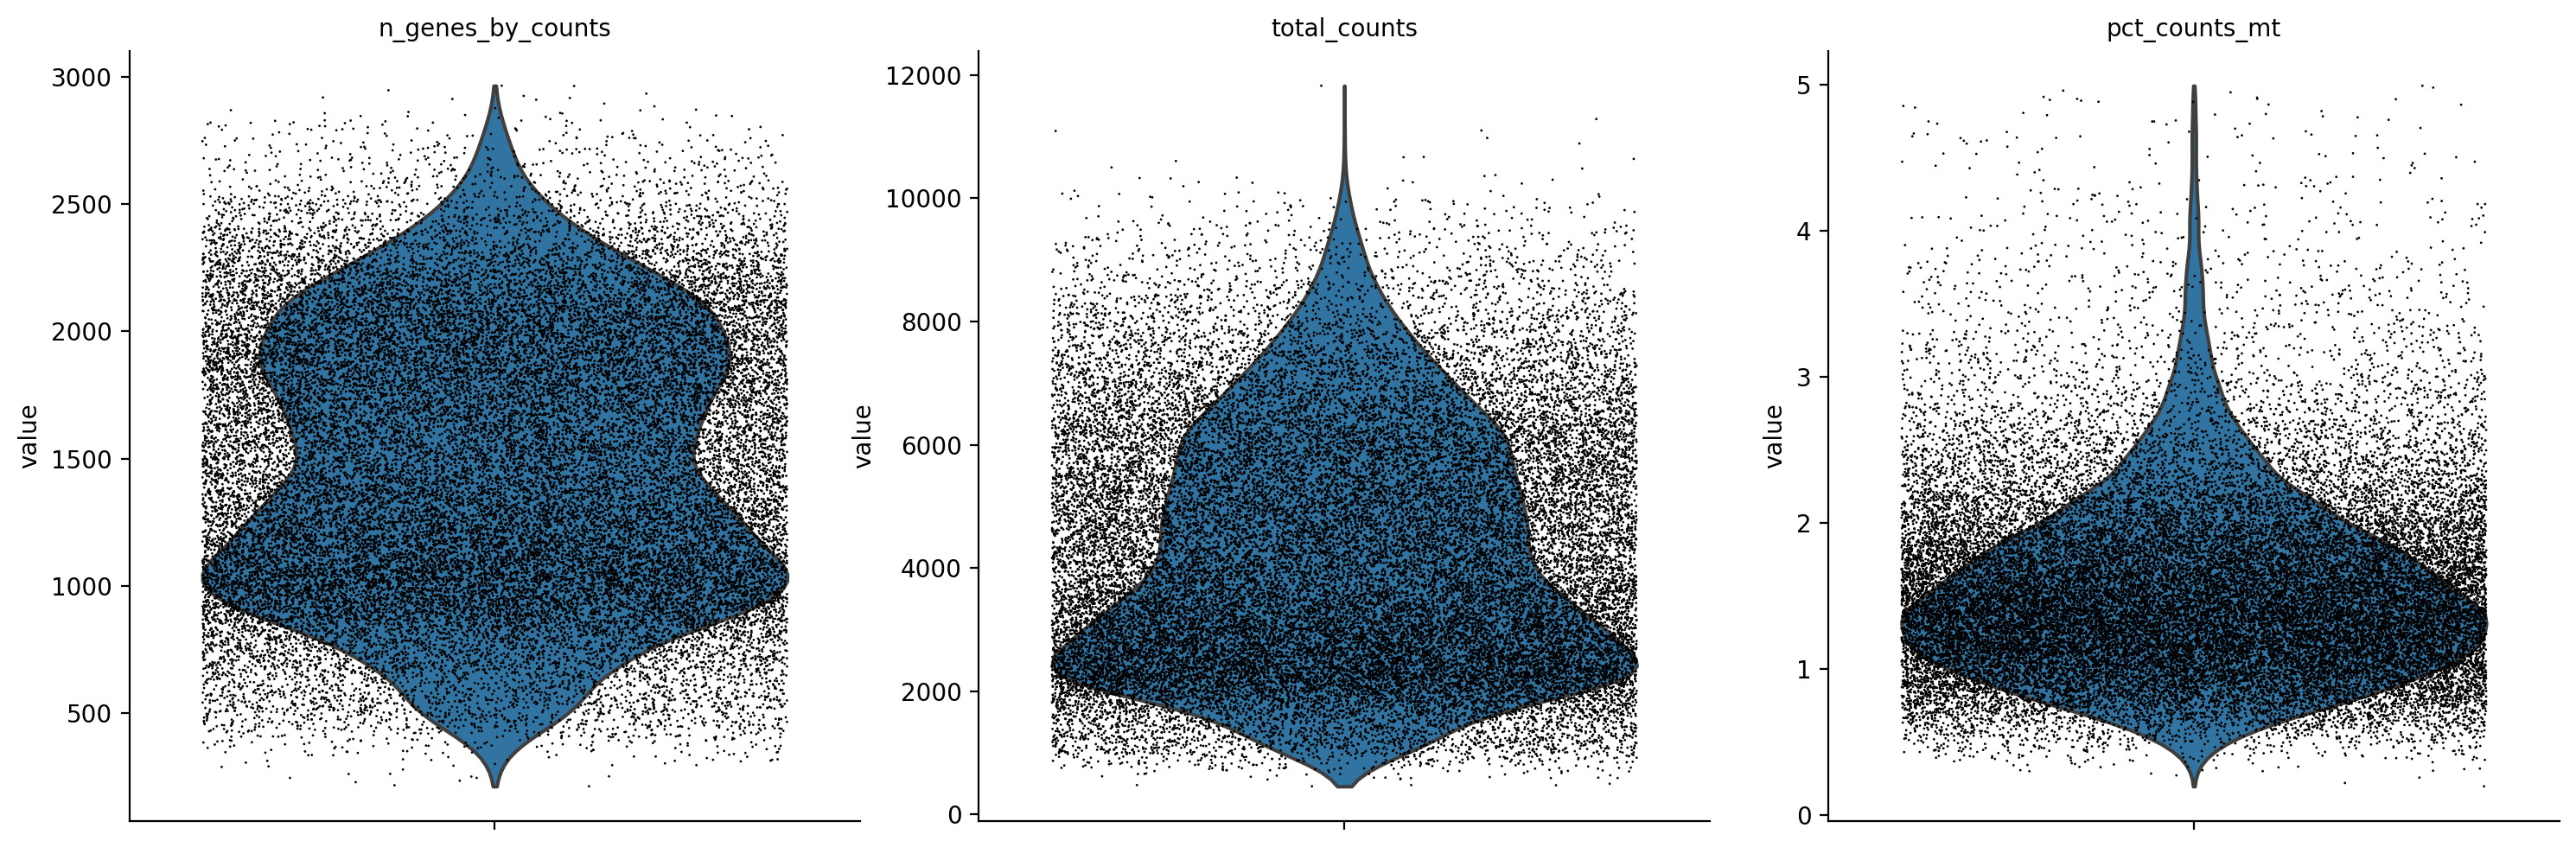

View of AnnData object with n_obs × n_vars = 33758 × 26274
    obs: 'area', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: '__type', 'spatial'
    obsm: 'X_spatial', 'bbox', 'contour', 'spatial'
    layers: 'spliced', 'unspliced'

In [4]:
# QC
adata.var['mt'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata = adata[adata.obs.n_genes_by_counts > 200, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)
adata

In [5]:
adata.obs['n_counts'] = adata.X.sum(axis=1).A1
adata.uns["pp"] = {}
adata.var_names_make_unique()
st.pp.filter.filter_genes(adata, min_cells=3)

AnnData object with n_obs × n_vars = 33758 × 23814
    obs: 'area', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'pass_basic_filter'
    uns: '__type', 'spatial', 'pp'
    obsm: 'X_spatial', 'bbox', 'contour', 'spatial'
    layers: 'spliced', 'unspliced'

In [6]:
dyn.pp.normalize_cell_expr_by_size_factors(adata, layers="X")
dyn.pp.log1p(adata)

|-----> rounding expression data of layer: X during size factor calculation
|-----> size factor normalize following layers: ['X']
|-----> applying <ufunc 'log1p'> to layer<X>
|-----> set adata <X> to normalized data.
|-----> <insert> pp.norm_method to uns in AnnData Object.
|-----> log1p transform applied to layers: ['X']


AnnData object with n_obs × n_vars = 33758 × 26274
    obs: 'area', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'Size_Factor', 'initial_cell_size'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: '__type', 'spatial', 'pp'
    obsm: 'X_spatial', 'bbox', 'contour', 'spatial'
    layers: 'spliced', 'unspliced'

In [7]:
st.tl.pca_spateo(adata, n_pca_components=50)
adata

AnnData object with n_obs × n_vars = 33758 × 26274
    obs: 'area', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'Size_Factor', 'initial_cell_size'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: '__type', 'spatial', 'pp'
    obsm: 'X_spatial', 'bbox', 'contour', 'spatial', 'X_pca'
    layers: 'spliced', 'unspliced'

In [8]:
dyn.tl.neighbors(adata, n_neighbors=30)
adata

|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.


AnnData object with n_obs × n_vars = 33758 × 26274
    obs: 'area', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'Size_Factor', 'initial_cell_size'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: '__type', 'spatial', 'pp', 'neighbors'
    obsm: 'X_spatial', 'bbox', 'contour', 'spatial', 'X_pca'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

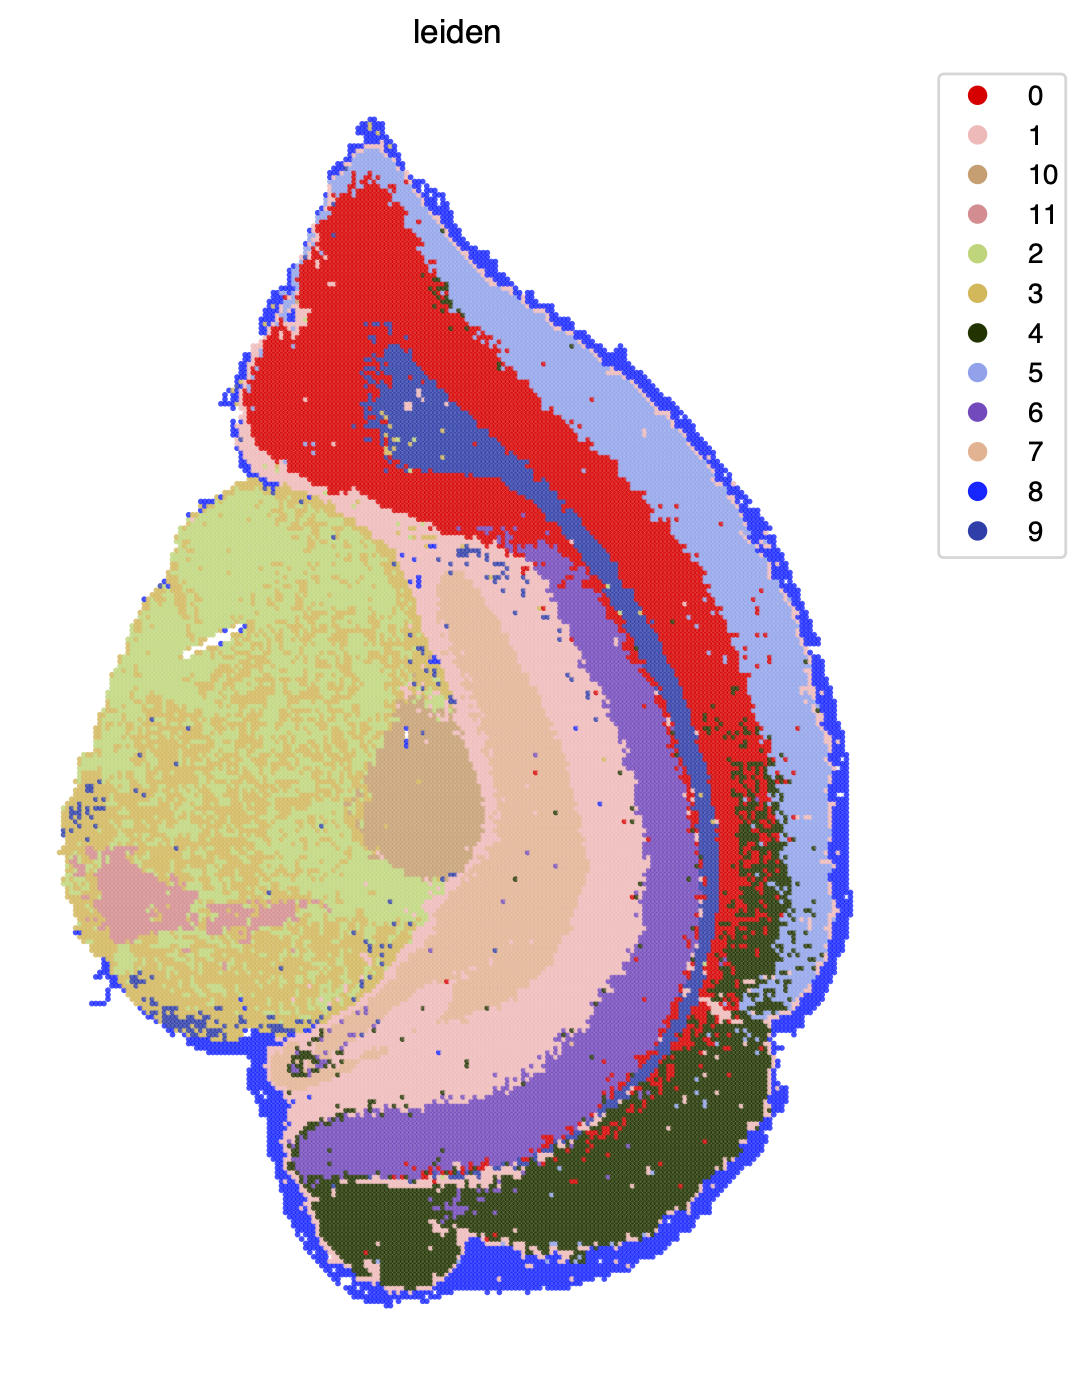

In [6]:
#dyn.tl.leiden(adata, resolution=1)
st.pl.space(adata, color=['leiden'], pointsize=0.2, show_legend="upper left")

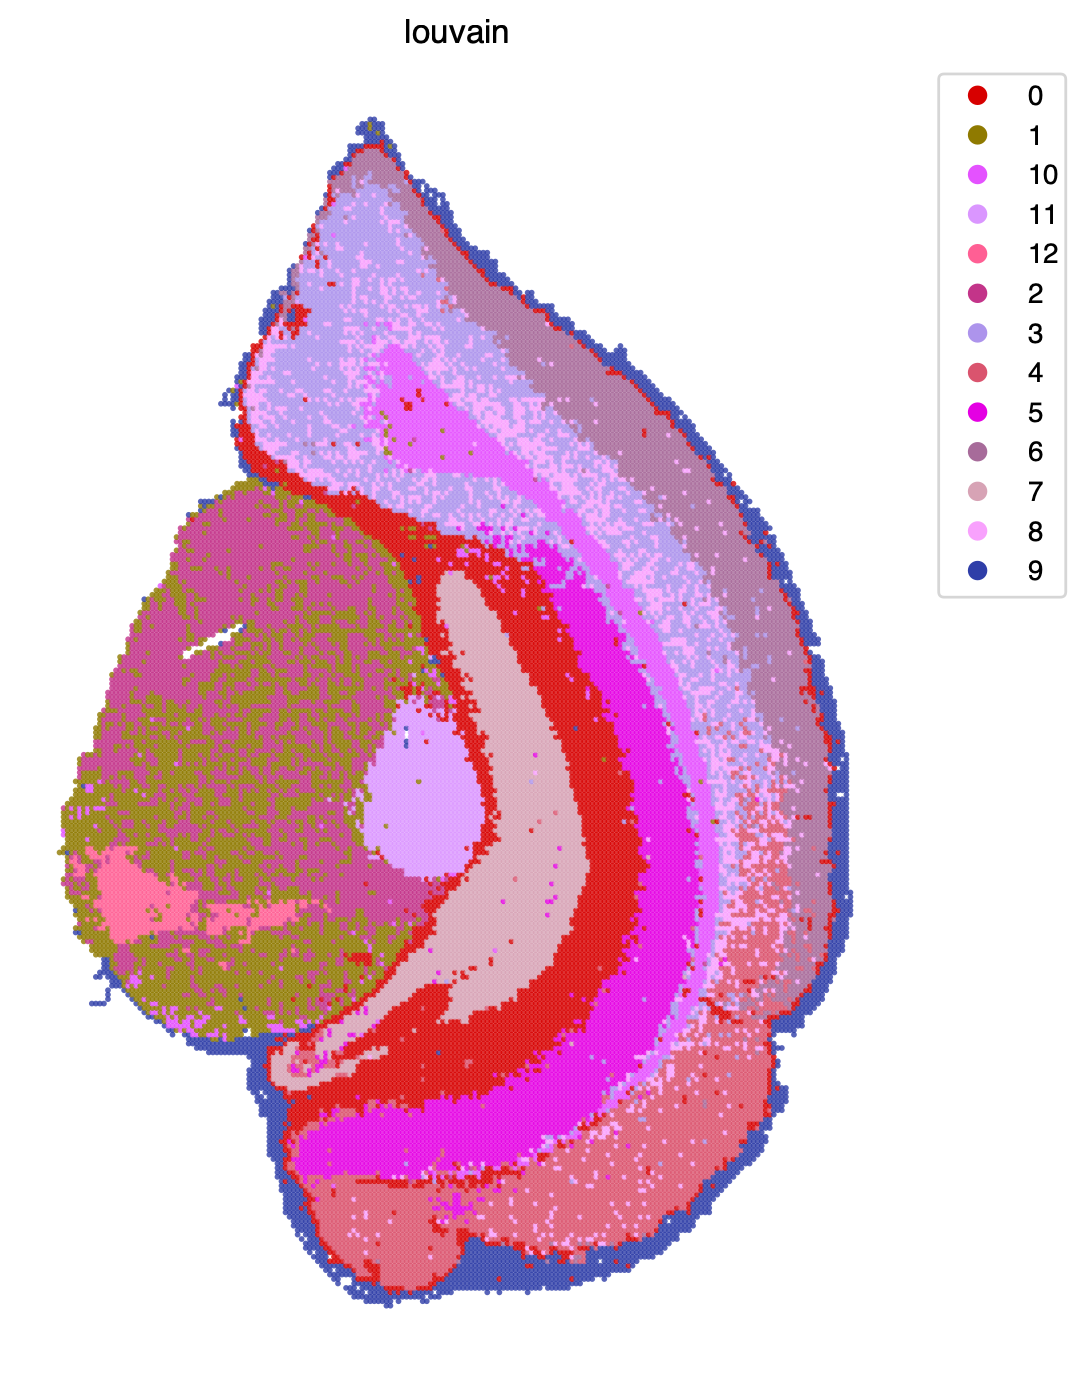

In [10]:
#dyn.tl.louvain(adata, resolution=1)
st.pl.space(adata, color=['louvain'], pointsize=0.2, show_legend="upper left")

Saving figure to ./scatters_bin50_scc_cluster.pdf...
Done


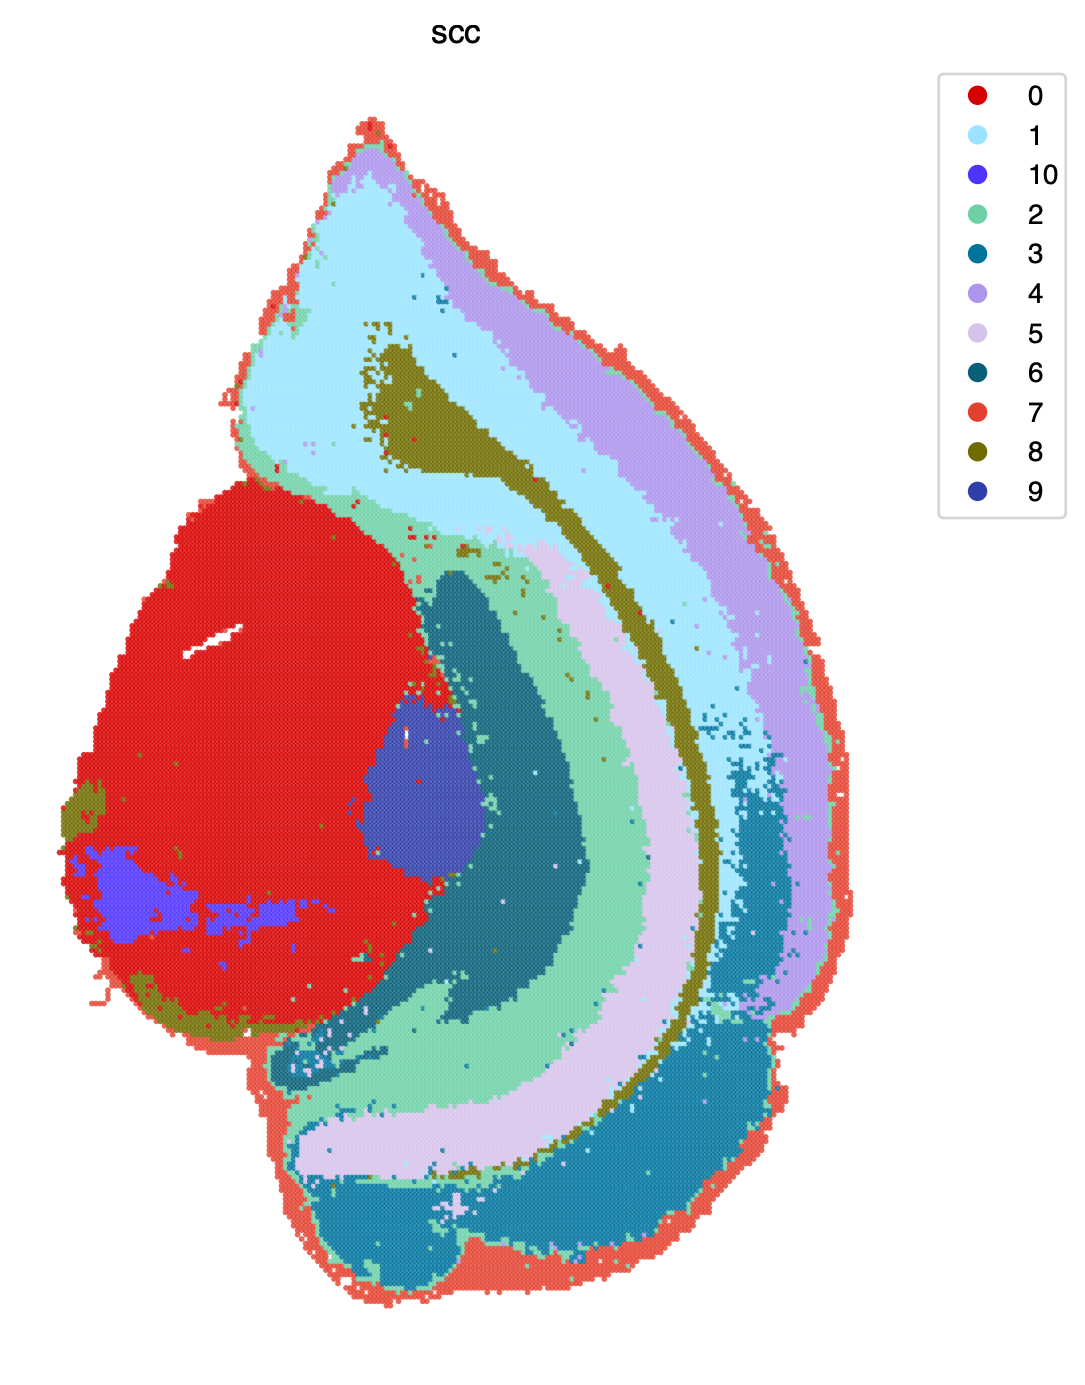

In [13]:
#st.tl.scc(adata, s_neigh=8, resolution=1, cluster_method="louvain", key_added="scc", pca_key="pca")
st.pl.space(adata, color=['scc'], pointsize=0.2, show_legend="upper left")
st.pl.space(adata, color=['scc'], pointsize=0.2, show_legend="upper left",
            save_show_or_return='save',save_kwargs={"path":"bin50_scc_cluster", "ext":"pdf", "dpi":300, "width":1,"heigth":1})

In [21]:
adata.write("adata_bin50_cluster.h5ad", compression='gzip')

In [3]:
adata = anndata.read("adata_bin50_cluster.h5ad")